In [1]:
import torch
from torch.utils import data
import torch.nn as nn
from glob import glob
import matplotlib.pyplot as plt
import librosa as li

In [2]:
class GuitarChord(data.Dataset):
    def __init__(self):
        self.liste = glob("AC_GuitarChords/*.wav")
        print("Preprocessing stuff... ", end="")
        
        for elm in self.liste:
            [x,fs] = li.load(elm)
            x = x[:4*fs]
            mel = li.filters.mel(fs,2048,500)
            S = torch.from_numpy(mel.dot(abs(li.stft(x,n_fft=2048,)))).float()
            torch.save(S,elm.replace(".wav",".pt"))
        
        print("Done!")
    def __getitem__(self,i):
        return torch.load(self.liste[i].replace(".wav",".pt"))
    
    def __len__(self):
        return len(self.liste)
            
class WAE(nn.Module):
    def __init__(self):
        super(WAE,self).__init__()
        size = [1, 16, 32, 64, 128, 256]
        zdim = 32
        
        self.act = nn.LeakyReLU()
        
        self.enc1 = nn.Conv2d(size[0],size[1],stride=2, kernel_size=5, padding=2)
        self.enc2 = nn.Conv2d(size[1],size[2],stride=2, kernel_size=5, padding=2)
        self.enc3 = nn.Conv2d(size[2],size[3],stride=2, kernel_size=5, padding=2)
        self.enc4 = nn.Conv2d(size[3],size[4],stride=2, kernel_size=5, padding=2)
        self.enc5 = nn.Conv2d(size[4],size[5],stride=2, kernel_size=5, padding=2)
        
        self.lin1 = nn.Linear(256*16*6, 1024)
        self.lin2 = nn.Linear(1024, 256)
        self.lin3 = nn.Linear(256, zdim)
        
        self.dec0 = nn.ConvTranspose2d(size[0],size[0],stride=2, kernel_size=5, padding=2)
        self.dec1 = nn.ConvTranspose2d(size[1],size[0],stride=2, kernel_size=5, padding=2)
        self.dec2 = nn.ConvTranspose2d(size[2],size[1],stride=2, kernel_size=5, padding=2)
        self.dec3 = nn.ConvTranspose2d(size[3],size[2],stride=2, kernel_size=5, padding=2)
        self.dec4 = nn.ConvTranspose2d(size[4],size[3],stride=2, kernel_size=5, padding=2)
        self.dec5 = nn.ConvTranspose2d(size[5],size[4],stride=2, kernel_size=5, padding=2)
        
        self.dlin1 = nn.Linear(1024,256*16*6)
        self.dlin2 = nn.Linear(256,1024)
        self.dlin3 = nn.Linear(zdim,256)
        
        self.f1   = nn.Sequential(self.enc1,
                                nn.BatchNorm2d(num_features=size[1]),self.act, 
                                self.enc2,
                                nn.BatchNorm2d(num_features=size[2]),self.act, 
                                self.enc3,
                                nn.BatchNorm2d(num_features=size[3]),self.act, 
                                self.enc4,
                                nn.BatchNorm2d(num_features=size[4]),self.act, 
                                self.enc5,
                                nn.BatchNorm2d(num_features=size[5]),self.act)
        
        self.f2   = nn.Sequential(self.lin1,
                                 nn.BatchNorm1d(num_features=1024),self.act,  
                                 self.lin2,
                                 nn.BatchNorm1d(num_features=256),self.act,
                                 self.lin3)
        
        self.f3   = nn.Sequential(self.dlin3,
                                  nn.BatchNorm1d(num_features=256), self.act,
                                  self.dlin2,
                                  nn.BatchNorm1d(num_features=1024), self.act,
                                  self.dlin1,
                                  nn.BatchNorm1d(num_features=256*16*6), self.act)
        
        self.f4   = nn.Sequential(self.dec5,
                                 nn.BatchNorm2d(num_features=size[4]), self.act,
                                 self.dec4,
                                 nn.BatchNorm2d(num_features=size[3]), self.act,
                                 self.dec3,
                                 nn.BatchNorm2d(num_features=size[2]), self.act,
                                 self.dec2,
                                 nn.BatchNorm2d(num_features=size[1]), self.act,
                                 self.dec1,
                                 nn.BatchNorm2d(num_features=size[0]), self.act,
                                 self.dec0, nn.Sigmoid(), nn.Upsample([500,173]))
                                  
        
        
        
    def flatten(self, inp):
        dim = 1
        for i,elm in enumerate(inp.size()):
            if i!=0:
                dim *= elm
        return inp.view(-1,dim)
    
    def encode(self, inp):
        inp = inp.unsqueeze(1)
        inp = self.f1(inp)
        inp = self.flatten(inp)
        inp = self.f2(inp)
        return inp
    
    def decode(self, inp):
        inp = self.f3(inp)
        inp = inp.view(-1, 256, 16, 6)
        inp = self.f4(inp)
        inp = inp.squeeze(1)
        return inp
        
    
    def forward(self,inp):
        return self.decode(self.encode(inp))
        
        
        
        

In [3]:
GC = GuitarChord()
GCloader = data.DataLoader(GC, batch_size=8, shuffle=True)

Preprocessing stuff... Done!


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()
model = WAE().to(device)

In [11]:
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

for idx, minibatch in enumerate(GCloader):
    
    minibatch = minibatch.to(device)
    
    optimizer.zero_grad()
    error = nn.functional.binary_cross_entropy(model(minibatch),minibatch)
    
    error.backward()
    optimizer.step()

/home/antoine/lap/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


RuntimeError: CUDA out of memory. Tried to allocate 96.00 MiB (GPU 0; 1.96 GiB total capacity; 1.13 GiB already allocated; 60.62 MiB free; 102.48 MiB cached)

In [7]:
a = model(minibatch)

/home/antoine/lap/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


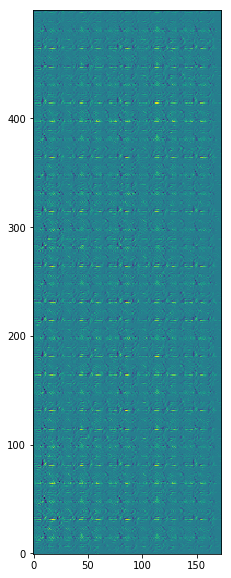

In [10]:
with torch.no_grad():
    s = a.cpu().detach().numpy()
    plt.figure(figsize=(10,10))
    plt.imshow(s[0,:,:], origin="lower")